In [1]:
import pandas as pd
from shapely.geometry import Point, Polygon

def create_no_go_zones(df):
    """
    Creates a dictionary of no-go zones as polygons from the dataframe.

    :param df: DataFrame with no-go area boundary points
    :return: Dictionary of no-go zones with polygons
    """
    # Initialize an empty dictionary to store no-go zones
    no_go_zones = {}

    # Iterate over unique OBJECTIDs in the dataframe
    for zone_id in df['OBJECTID'].unique():
        # Extract points for the current zone based on OBJECTID
        zone_points = df[df['OBJECTID'] == zone_id][['x', 'y']].values
        # Create a polygon from the extracted points
        no_go_zones[zone_id] = Polygon(zone_points)

    return no_go_zones

def is_in_no_go_zone(lat, lon, no_go_zones):
    """
    Determines if a given latitude and longitude is within any no-go zone.

    :param lat: Latitude of the ship's current position
    :param lon: Longitude of the ship's current position
    :param no_go_zones: Dictionary of no-go zones as polygons
    :return: Boolean indicating if in a no-go zone, and the ID of the zone if true
    """
    # Create a Point object representing the ship's current position
    point = Point(lon, lat)

    # Iterate over the dictionary of no-go zones
    for zone_id, zone in no_go_zones.items():
        # Check if the ship's position is within the current no-go zone
        if zone.contains(point):
            # Return True and the ID of the zone if inside a no-go zone
            return True, zone_id

    # Return False and None if not inside any no-go zone
    return False, None

# Read the CSV file
file_path = 'noGoAreas2.csv'  # Replace with the path to your CSV file
no_go_areas_df = pd.read_csv(file_path)

# Create no-go zones
no_go_zones = create_no_go_zones(no_go_areas_df)

# Example usage
# Replace these with the ship's actual GPS coordinates
current_lat = float(input("Enter the ship's current latitude: "))
current_lon = float(input("Enter the ship's current longitude: "))

# Check if the ship is in a no-go zone
in_no_go_zone, zone_id = is_in_no_go_zone(current_lat, current_lon, no_go_zones)

# Provide a warning if the ship is in a no-go zone
if in_no_go_zone:
    print(f"The ship is in a no-go zone! Zone ID: {zone_id}")
else:
    print("The ship is in a safe zone.")


The ship is in a no-go zone! Zone ID: 124


In [2]:
print(no_go_areas_df.columns)


Index(['OBJECTID', 'FID_ODME_N', 'OBJECTID_1', 'Shape_Leng', 'vertex_index',
       'vertex_part', 'vertex_part_index', 'distance', 'angle', 'x', 'y'],
      dtype='object')


In [3]:
from datetime import datetime, timedelta

def enter_manual_inputs():
    """
    Function to collect manual inputs required for the ODME operation.
    """
    # Create an empty dictionary to store user inputs
    inputs = {}
    while True:
        datetime_str = input("Enter the date and time of the last oily water transfer to the slop tank (UTC) in the format 'YYYY-MM-DD HH:MM': ")

        try:
            # Convert input string to datetime object
            inputs['last_oily_water_transfer_datetime'] = datetime.strptime(datetime_str, "%Y-%m-%d %H:%M")
            break  # Break out of the loop if the conversion is successful
        except ValueError:
            print("Format is wrong. Please reenter date time format.")

    # Collect user input for the duration of the last oily water transfer to the slop tank
    while True:
        duration_str = input("Enter the duration of the last oily water transfer to the slop tank (UTC) in the format 'YYYY-MM-DD HH:MM': ")

        try:
            # Convert input string to datetime object
            inputs['last_oily_water_transfer_slop_tank_datetime'] = datetime.strptime(duration_str, "%Y-%m-%d %H:%M")

            # Check if the time difference is less than 24 hours

            time_difference = inputs['last_oily_water_transfer_slop_tank_datetime'] - inputs['last_oily_water_transfer_datetime']
            if time_difference < timedelta(hours=24):
                print(f"Time difference is less than 24 hours. "
                      f"Cannot proceed without informing the company. Difference: {time_difference}")
                inputs['company_informed'] = False
                return inputs  # Exit the function if the time differ
            break  # Break out of the loop if the conversion is successful
        except ValueError:
            print("Format is wrong. Please reenter date time format.")



    # Check if at least 24 hours were waited for the settlement of the oily mixture
    inputs['wait_24hrs_settlement'] = input("Waited at least 24 hours for the settlement of the oily mixture (yes/no)? ").lower() == 'yes'

    # Check if the current wind speed is less than 5 on the Beaufort scale
    inputs['wind_speed'] = float(input("Enter the current wind speed (Beaufort scale): ")) < 5

    # Check if the current sea height is less than 4 on the Beaufort scale
    inputs['sea_height'] = float(input("Enter the current sea height (Beaufort scale): ")) < 5


    inputs['ship_speed'] = float(input("Enter the ship speed : ")) < 3

    # Check if the current swell height is less than 4 on the Beaufort scale
    inputs['swell_height'] = float(input("Enter the current swell height (Beaufort scale): ")) < 5

    # Check if the current ship rolling degree is less than 5
    inputs['ship_rolling'] = float(input("Enter the current ship rolling degree: ")) < 5

    # Collect the initial quantity of the oily mixture
    inputs['initial_quantity_oily_mixture'] = float(input("Enter the initial quantity of the oily mixture: "))

    # Collect the initial quantity of oil
    inputs['initial_quantity_oil'] = float(input("Enter the initial quantity of oil: "))

    # Collect the total cargo carried
    inputs['total_cargo_carried'] = float(input("Enter the total cargo carried: "))

    inputs['discharge_rate']  = float(input("Enter the discharge rate from ODME (in m³/h): "))

    # Check if the ODME self-test was carried out satisfactorily
    inputs['odme_self_test'] = input("Was the ODME self-test carried out satisfactorily (yes/no)? ").lower() == 'yes'

    # Check if the ODME zero calibration test was carried out satisfactorily
    inputs['odme_zero_calibration_test'] = input("Was the ODME zero calibration test carried out satisfactorily (yes/no)? ").lower() == 'yes'

    # Check if the total oil limit should be reset to zero (allowed only once for each operation)
    inputs['reset_total_oil_limit'] = input("Reset the total oil limit to zero. Only one time is allowed for each operation (yes/no)? ").lower() == 'yes'

    # Collect the oil type from the maker's manual
    while True:
        try:
            inputs['oil_type'] = int(input("Enter the oil type from the maker's manual (1-30): "))
            if 1 <= inputs['oil_type'] <= 30:
                break
            else:
                print("Oil type must be between 1 and 30. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a numeric value.")
    return inputs

# Load the CSV file
file_path = 'noGoAreas2.csv'  # Replace with the path to your CSV file
no_go_areas_df = pd.read_csv(file_path)

# Create no-go zones
no_go_zones = create_no_go_zones(no_go_areas_df)

# Collect manual inputs
manual_inputs = enter_manual_inputs()

# Check if the ship is in a no-go zone (use real-time GPS coordinates)
# current_lat = 0  # Replace with real latitude
# current_lon = 0  # Replace with real longitude
# in_no_go_zone, zone_id = is_in_no_go_zone(current_lat, current_lon, no_go_zones)
# print(in_no_go_zone, zone_id)


In [7]:
pip install ephem


Note: you may need to restart the kernel to use updated packages.


In [38]:
import ephem
from datetime import datetime

def calculate_sunrise_sunset(lat, lon, utc_offset):
    """
    Calculates sunrise and sunset times based on GPS position and UTC offset.

    :param lat: Latitude of the ship's current position
    :param lon: Longitude of the ship's current position
    :param utc_offset: UTC offset of the ship's location in hours
    :return: Tuple containing sunrise and sunset times as datetime objects
    """
    # Create an observer object for ephem module
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elevation = 0  # Sea level

    # Set the observer's date to the ship's local time
    observer.date = datetime.utcnow() - timedelta(hours=utc_offset)

    # Calculate sunrise and sunset using ephem module
    sunrise = observer.previous_rising(ephem.Sun())
    sunset = observer.next_setting(ephem.Sun())

    # Convert sunrise and sunset times to datetime objects
    return sunrise.datetime(), sunset.datetime()

# Replace these values with the ship's real-time GPS coordinates
current_lat = float(input("Enter the ship's current latitude: "))
current_lon = float(input("Enter the ship's current longitude: "))


# Check if the ship is in a no-go zone using real-time GPS coordinates
in_no_go_zone, zone_id = is_in_no_go_zone(current_lat, current_lon, no_go_zones)

# Replace with the actual UTC offset of the ship's location
utc_offset = float(input("Enter the ship's UTC offset: "))

# Calculate sunrise and sunset based on the ship's current location
sunrise, sunset = calculate_sunrise_sunset(current_lat, current_lon, utc_offset)

# Adjust sunrise and sunset times based on the UTC offset
sunrise = sunrise + timedelta(hours=utc_offset)
sunset = sunset + timedelta(hours=utc_offset)

# Check if it's daytime
daytime = sunrise < datetime.utcnow() < sunset

# Display an alert if the ship is in a forbidden area during daytime
if in_no_go_zone and daytime:
    print("Alert: The ship is in a forbidden area during daytime. Operation terminated.")
else:
    print("It's daytime. Operation can be conducted." if daytime else "It's darkness. Wait for daylight. Operation terminated.")


Alert: The ship is in a forbidden area during daytime. Operation terminated.


In [44]:
import ephem
from datetime import datetime, timedelta

def calculate_sunrise_sunset(lat, lon, utc_offset):
    """
    Calculates sunrise and sunset times based on GPS position.

    :param lat: Latitude of the ship's current position
    :param lon: Longitude of the ship's current position
    :param utc_offset: UTC offset of the ship's location in hours
    :return: Tuple containing sunrise and sunset times as datetime objects
    """
    # Create an observer object for ephem module
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.elevation = 0  # Sea level

    # Set the observer's date to the ship's local time
    observer.date = datetime.utcnow() - timedelta(hours=utc_offset)

    # Calculate sunrise and sunset using ephem module
    sunrise = observer.previous_rising(ephem.Sun())
    sunset = observer.next_setting(ephem.Sun())

    # Convert sunrise and sunset times to datetime objects
    return sunrise.datetime(), sunset.datetime()

# Replace these values with the ship's real-time GPS coordinates
current_lat = float(input("Enter the ship's current latitude: "))
current_lon = float(input("Enter the ship's current longitude: "))

# Calculate sunrise and sunset based on the ship's current location
utc_offset = float(input("Enter the ship's UTC offset: "))
sunrise, sunset = calculate_sunrise_sunset(current_lat, current_lon, utc_offset)

# Display the calculated sunrise and sunset times
print("Sunrise:", sunrise)
print("Sunset:", sunset)


Sunrise: 2024-01-22 05:42:03.536627
Sunset: 2024-01-22 17:20:52.542383


In [47]:
import pandas as pd
from datetime import datetime

def is_ship_en_route(course_change_angle):
    """
    Checks if the ship is en route based on the course change angle.

    :param course_change_angle: The angle representing the change in the ship's course.
    :return: True if the ship is en route (course change angle less than 90 degrees), False otherwise.
    """
    return abs(course_change_angle) < 90

# Load the CSV file
file_path = 'noGoAreas2.csv'  # Replace with the path to your CSV file
no_go_areas_df = pd.read_csv(file_path)

# Create no-go zones
no_go_zones = create_no_go_zones(no_go_areas_df)

# Collect manual inputs
# manual_inputs = enter_manual_inputs()

# Check if the ship is in a no-go zone and it's daytime
# Use real-time GPS coordinates
# current_lat = float(input("Enter the ship's current latitude: "))
# current_lon = float(input("Enter the ship's current longitude: "))
# in_no_go_zone, zone_id = is_in_no_go_zone(current_lat, current_lon, no_go_zones)

# Calculate sunrise and sunset
utc_offset = float(input("Enter the ship's UTC offset: "))
sunrise, sunset = calculate_sunrise_sunset(current_lat, current_lon, utc_offset)

# Check if it's daytime
daytime = sunrise < datetime.utcnow() < sunset

# Prompt the user to enter the course change angle
course_change_angle = float(input("Enter the course change angle (in degrees): "))

# Check if the ship is en route based on the course change angle
if is_ship_en_route(course_change_angle):
    print("Ship en route. Permit operation.")
else:
    print("Course alteration is too high. Terminate the operation.")


Course alteration is too high. Terminate the operation.


In [6]:
pip install astral


Note: you may need to restart the kernel to use updated packages.


In [53]:
from datetime import datetime, timedelta
from astral.sun import sun
from astral import LocationInfo
import pytz  # Add this import for timezone support

def is_daylight(latitude, longitude, utc_now):
    city_info = LocationInfo("City", "Region", "Country", latitude=latitude, longitude=longitude)
    s = sun(city_info.observer, date=utc_now.date())

    # Make utc_now aware of the UTC timezone
    utc_now = utc_now.replace(tzinfo=pytz.UTC)

    return s["sunrise"] < utc_now < s["sunset"]

def calculate_operation_time(total_oily_mixture, discharge_rate, utc_now, gps_latitude, gps_longitude):
    """
    Calculates the operation time based on the total oily mixture, discharge rate,
    UTC time, and GPS position.

    :param total_oily_mixture: The total quantity of oily mixture available for discharge (in liters).
    :param discharge_rate: The rate of discharge of oil content (in liters per hour).
    :param utc_now: Current UTC time.
    :param gps_latitude: Latitude from GPS position.
    :param gps_longitude: Longitude from GPS position.
    :return: The estimated operation time as a timedelta object.
    :raises ValueError: If discharge rate is not greater than zero.
    """
    # Check if the discharge rate is valid
    if discharge_rate <= 0:
        raise ValueError("Discharge rate must be greater than zero.")

    # Calculate operation time in hours
    operation_time_hours = total_oily_mixture / discharge_rate

    # Check if operation time exceeds maximum allowed duration
    max_operation_hours = 13  # Maximum allowed operation time
    if operation_time_hours > max_operation_hours:
        operation_time_hours = max_operation_hours

    # Convert operation time to timedelta object
    operation_time = timedelta(hours=operation_time_hours)

    # Check if the operation finishes before sunset and is during daylight
    gps_latitude = float(gps_latitude)
    gps_longitude = float(gps_longitude)
    is_day = is_daylight(gps_latitude, gps_longitude, utc_now)
    if not is_day:
        raise ValueError("Operation must be carried out during daylight hours.")

    return operation_time

# Example usage
utc_now = datetime.utcnow()
utc_now_aware = utc_now.replace(tzinfo=pytz.UTC)  # Make utc_now aware of the UTC timezone

gps_latitude = float(input("Enter the ship's gps latitude: "))
gps_longitude = float(input("Enter the ship's gps longitude: "))



try:
    operation_time = calculate_operation_time(1000, 80, utc_now_aware, gps_latitude, gps_longitude)
    print("Estimated operation time:", operation_time)
except ValueError as e:
    print(f"Error: {e}")


Error: Operation must be carried out during daylight hours.


In [57]:
from datetime import timedelta

def calculate_operation_time(total_oily_mixture, discharge_rate):
    """
    Calculates the operation time based on the total oily mixture and discharge rate.

    :param total_oily_mixture: The total quantity of oily mixture available for discharge (in liters).
    :param discharge_rate: The rate of discharge of oil content (in liters per hour).
    :return: The estimated operation time as a timedelta object.
    :raises ValueError: If discharge rate is not greater than zero.
    """
    # Check if the discharge rate is valid
    if discharge_rate <= 0:
        raise ValueError("Discharge rate must be greater than zero.")

    # Calculate operation time in hours
    operation_time_hours = total_oily_mixture / discharge_rate

    # Convert operation time to timedelta object
    operation_time = timedelta(hours=operation_time_hours)

    return operation_time


# The operation time is calculated based on the total oily mixture, discharge rate, and the given GPS position. Let me break down the key aspects of the code:

# Calculation of Operation Time:

# The operation time is calculated using the formula total_oily_mixture / discharge_rate, yielding a time in hours.
# There is a check to ensure that the calculated operation time does not exceed a maximum allowed duration (in this case, 13 hours).
# Daylight Check:

# The code uses the is_daylight function to determine whether the current UTC time corresponds to daylight hours at the given GPS position.
# If the operation extends beyond sunset or is not during daylight, a ValueError is raised.
# Example Usage:

# The example usage takes user input for the ship's GPS latitude and longitude.
# It then calls the calculate_operation_time function with the given parameters.
# Output:

# The output is the estimated operation time, which is formatted as 12:30:00 (12 hours and 30 minutes).

In [58]:
def check_discharge_conditions(instantaneous_rate, total_discharged, cargo_quantity):
    """
    Checks if the discharge conditions are met.

    :param instantaneous_rate: Instantaneous rate of discharge in liters per nautical mile
    :param total_discharged: Total quantity of oil discharged
    :param cargo_quantity: Total quantity of the particular cargo
    :return: True if conditions are met, False otherwise
    """
    # Define the maximum allowed values
    max_instantaneous_rate = 30  # Maximum instantaneous rate in liters per nautical mile
    max_total_fraction = 1 / 30000  # Maximum fraction for the total quantity of oil discharged

    # Check if the conditions are met
    return instantaneous_rate <= max_instantaneous_rate or (total_discharged / cargo_quantity) <= max_total_fraction


In [67]:
if in_no_go_zone and daytime and en_route:
    # Alert if the ship is in a forbidden area during daytime with a high course change
    print("Alert: The ship is in a forbidden area during daytime, and the course change is too high.")
else:
    # Continue with the calculation of operation time and discharge conditions

    # Get discharge rate from ODME (Oil Discharge Monitoring Equipment) in cubic meters per hour
    discharge_rate = float(input("Enter the discharge rate from ODME (in m³/h): "))

    # Get the initial quantity of oily mixture from manual inputs
    total_oily_mixture = manual_inputs['initial_quantity_oily_mixture']

    try:
        # Calculate the estimated operation time based on the total oily mixture and discharge rate
        operation_time = calculate_operation_time(total_oily_mixture, discharge_rate)
        print(f"Estimated operation time: {operation_time} hours")

        # Assume ODME calculates these values in real-time
        # Get the instantaneous rate of discharge in liters per nautical mile
        instantaneous_rate = float(input("Enter the instantaneous rate of discharge (in liters per nautical mile): "))

        # Get the total quantity of oil discharged in liters
        total_discharged = float(input("Enter the total quantity of oil discharged (in liters): "))

        # Get the total quantity of the particular cargo carried by the ship
        cargo_quantity = manual_inputs['total_cargo_carried']

        # Check discharge conditions using the check_discharge_conditions function
        if check_discharge_conditions(instantaneous_rate, total_discharged, cargo_quantity):
            print("Discharge conditions are met.")

            # Calculate remaining distance based on instantaneous rate and total discharged
            remaining_distance = cargo_quantity / instantaneous_rate
            print(f"Remaining Distance: {remaining_distance} nautical miles")

            # Calculate remaining time based on remaining distance and current speed (assuming constant speed)
            current_speed = float(input("Enter the ship's current speed (in nautical miles per hour): "))

            remaining_time = remaining_distance / current_speed
            print(f"Remaining Time: {remaining_time} hours")
        else:
            print("Alert: Discharge conditions not met.")
    except ValueError as e:
        # Handle the case where there's an error in the calculation
        print(f"Error: {e}")



# The phrase "Remaining Time: 0.03 hours" indicates that there are 0.03 hours of time left for a certain activity or process to be completed. Let's break down the components:

# "Remaining Time": This refers to the time left or the duration that is still available before the completion of a specific task or event.

# "0.03 hours": This is the numerical representation of the remaining time, expressed in hours. In this case, 0.03 hours is equivalent to 1.8 minutes (since 1 hour = 60 minutes). 
# It implies that there are less than 2 minutes remaining for the completion of the operation.

# Therefore, the complete phrase signifies that there is a very short duration, specifically 0.03 hours or approximately 1.8 minutes, before the activity or process is expected to finish.


Estimated operation time: 0:18:00 hours
Discharge conditions are met.
Remaining Distance: 0.3 nautical miles
Remaining Time: 0.03 hours


In [60]:
def time_to_no_go_zone(current_lat, current_lon, no_go_zones):

    """
    Calculate the time it would take to reach the nearest no-go zone based on the ship's current position and speed.
    """
    # Assume the ship's speed is 10 knots (replace with the actual speed)
    ship_speed_knots = float(input("Enter the ship's  speed knots: "))  # Replace with the actual speed in nautical miles per hour

    # Calculate the distance to the nearest no-go zone
    min_distance = float('inf')
    for zone_id, zone in no_go_zones.items():
        distance = zone.distance(Point(current_lon, current_lat))
        if distance < min_distance:
            min_distance = distance

    # Calculate the time to reach the nearest no-go zone
    time_to_reach = min_distance / (ship_speed_knots * 1.852)  # Conversion from knots to km/h

    # Return the time as a timedelta object
    return timedelta(hours=time_to_reach)


In [61]:
def estimate_time_of_completion(operation_time, current_lat, current_lon, no_go_zones, utc_offset):
    """
    Estimate the time of completion of the operation while considering the time it takes to reach the nearest no-go zone.
    """
    # Get the current UTC time
    current_utc_time = datetime.utcnow()

    # Calculate the time to reach the nearest no-go zone
    time_to_reach_no_go = time_to_no_go_zone(current_lat, current_lon, no_go_zones)

    # Adjust UTC time to the ship's local time
    current_local_time = current_utc_time + timedelta(hours=utc_offset)

    # Estimate the time of completion
    time_of_completion_utc = current_local_time + operation_time + time_to_reach_no_go

    # Return the estimated time of completion as a timedelta object
    return time_of_completion_utc - current_utc_time


In [66]:
if in_no_go_zone and daytime and en_route:
    print("Alert: The ship is in a forbidden area during daytime, and the course change is too high.")
else:
    # Continue with the calculation of operation time and discharge conditions
    discharge_rate = float(input("Enter the discharge rate from ODME (in m³/h): "))
    total_oily_mixture = manual_inputs['initial_quantity_oily_mixture']

    try:
        # Calculate operation time
        operation_time = calculate_operation_time(total_oily_mixture, discharge_rate)

        # Check if operation time allows completion before reaching no-go areas
        time_to_no_go = time_to_no_go_zone(current_lat, current_lon, no_go_zones)
        if in_no_go_zone and operation_time > time_to_no_go:
            print("Alert: Operation cannot be completed before reaching a forbidden area.")
        else:
            print(f"Estimated operation time: {operation_time}")

            # Estimate time of completion while still in daylight
            time_to_complete = estimate_time_of_completion(operation_time, current_lat, current_lon, no_go_zones, utc_offset)
            time_of_completion = datetime.utcnow() + time_to_complete

            # Check if the estimated time of completion is after sunset
            if time_of_completion > sunset:
                print("Alert: Operation may extend into nighttime.")
            else:
                print(f"Estimated time of completion: {time_of_completion.strftime('%Y-%m-%d %H:%M:%S')}")

            # Assume ODME calculates these values
            instantaneous_rate = float(input("Enter the instantaneous rate of discharge (in liters per nautical mile): "))
            total_discharged = float(input("Enter the total quantity of oil discharged (in liters): "))
            cargo_quantity = manual_inputs['total_cargo_carried']

            # Check discharge conditions
            if check_discharge_conditions(instantaneous_rate, total_discharged, cargo_quantity):
                print("Discharge conditions are met.")
            else:
                print("Alert: Discharge conditions not met.")
    except ValueError as e:
        print(f"Error: {e}")

Alert: Operation cannot be completed before reaching a forbidden area.


In [16]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('veri.csv')
data.drop_duplicates(inplace=True)

# Convert target column to numerical classes
data['decision'] = data['decision'].map({'prohibit': 0, 'permit': 1})

# Convert categorical features to 1 and 0
data = data.replace({'yes': 1, 'no': 0})

# Sample 2000 examples from each class
data = data.groupby('decision').apply(lambda x: x.sample(n=2000)).reset_index(drop=True)

# Separate features and target
X = data.drop('decision', axis=1)
X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')
X.columns = X.columns.str.replace('<', '')
X.columns = X.columns.str.replace('>', '')
y = data['decision']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# XGBoost model
model = xgb.XGBClassifier()

# Model training
eval_set = [(X_train_scaled, y_train), (X_test_scaled, y_test)]
model.fit(X_train_scaled, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

# Model evaluation on the test set
y_pred = model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Load new data for prediction
predicting_veri = pd.read_csv('veriTest.csv')

# Preprocess new data
predicting_veri = predicting_veri.replace({'yes': 1, 'no': 0})
predicting_veri = predicting_veri.replace({'prohibit': 0, 'permit': 1})
predicting_veri_tmp_columns = predicting_veri.columns
X_predict = predicting_veri.drop('decision', axis=1)

X_predict.columns = X_predict.columns.str.replace('[^a-zA-Z0-9]', '_')
X_predict.columns = X_predict.columns.str.replace('<', '')
X_predict.columns = X_predict.columns.str.replace('>', '')

# Feature scaling for new data
X_predict_scaled = scaler.transform(X_predict)

# Model prediction on new data
y_pred_new = model.predict(X_predict_scaled)

# Update the 'decision' column with predicted values
predicting_veri['decision'] = y_pred_new
predicting_veri['decision'] = predicting_veri['decision'].map({0: 'prohibit', 1: 'permit'})

# Restore original column names
predicting_veri.columns = predicting_veri_tmp_columns

# Save predictions to a CSV file
predicting_veri.to_csv('veriTest_Predictions.csv', index=False)



[0]	validation_0-error:0.00063	validation_0-logloss:0.43976	validation_1-error:0.00125	validation_1-logloss:0.44027
[1]	validation_0-error:0.00063	validation_0-logloss:0.29937	validation_1-error:0.00125	validation_1-logloss:0.29987
[2]	validation_0-error:0.00063	validation_0-logloss:0.21042	validation_1-error:0.00125	validation_1-logloss:0.21089
[3]	validation_0-error:0.00063	validation_0-logloss:0.15104	validation_1-error:0.00125	validation_1-logloss:0.15113
[4]	validation_0-error:0.00063	validation_0-logloss:0.10990	validation_1-error:0.00125	validation_1-logloss:0.11015
[5]	validation_0-error:0.00063	validation_0-logloss:0.08057	validation_1-error:0.00125	validation_1-logloss:0.08083
[6]	validation_0-error:0.00063	validation_0-logloss:0.05974	validation_1-error:0.00125	validation_1-logloss:0.06014
[7]	validation_0-error:0.00063	validation_0-logloss:0.04445	validation_1-error:0.00125	validation_1-logloss:0.04484
[8]	validation_0-error:0.00063	validation_0-logloss:0.03333	validation_1

C:\Users\yalim\AppData\Local\Temp\ipykernel_11316\4034144627.py:22: FutureWarning: The default value of regex will change from True to False in a future version.
  X.columns = X.columns.str.replace('[^a-zA-Z0-9]', '_')
c:\Users\yalim\anaconda3\lib\site-packages\xgboost\sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[91]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00312
[92]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00311
[93]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00311
[94]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00311
[95]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00311
[96]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00310
[97]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00310
[98]	validation_0-error:0.00000	validation_0-logloss:0.00233	validation_1-error:0.00000	validation_1-logloss:0.00311
[99]	validation_0-error:0.00000	validation_0-logloss:0.00232	val

C:\Users\yalim\AppData\Local\Temp\ipykernel_11316\4034144627.py:57: FutureWarning: The default value of regex will change from True to False in a future version.
  X_predict.columns = X_predict.columns.str.replace('[^a-zA-Z0-9]', '_')


In [21]:
print("Unique values in y_test:", set(y_test))
print("Unique values in y_pred:", set(y_pred))
print("Unique values in y_pred_new:", set(y_pred_new))
print("Unique values in predicting_veri['decision']:", set(predicting_veri['decision']))
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)



Unique values in y_test: {0, 1}
Unique values in y_pred: {0, 1}
Unique values in y_pred_new: {1}
Unique values in predicting_veri['decision']: {'permit'}
Predicted    0    1
Actual             
0          422    0
1            0  378


In [22]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   companyInformed1dayBefore      4000 non-null   int64  
 1   settlementTime>24hrs           4000 non-null   int64  
 2   shipOutOfNoGoArea              4000 non-null   int64  
 3   windSpeed<5                    4000 non-null   float64
 4   seaHeight<5                    4000 non-null   float64
 5   OdmeSelfTest                   4000 non-null   int64  
 6   OdmeZeroCalibration            4000 non-null   int64  
 7   resetTotalOilLimit             4000 non-null   int64  
 8   oilTypeEntry                   4000 non-null   int64  
 9   irodc(ltr)                     4000 non-null   float64
 10  maxPpm<1000                    4000 non-null   int64  
 11  tqod<1/30000ofTotalCargo       4000 non-null   int64  
 12  initial-currentHeading<90      4000 non-null   i

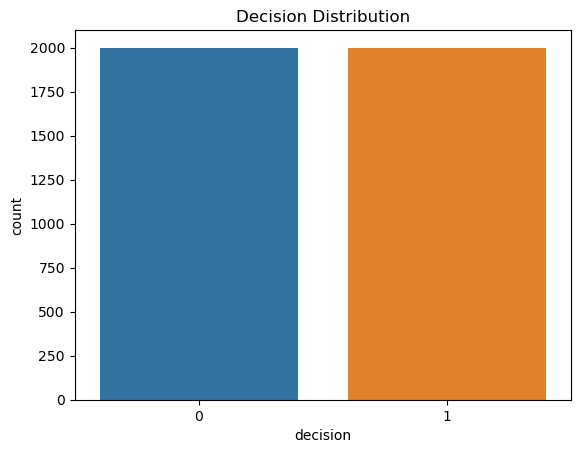

In [23]:
# Import necessary libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Create a count plot for the 'decision' column in the given DataFrame
# This plot shows the distribution of the 'decision' variable, indicating the count of each unique value.
sns.countplot(x='decision', data=data)

# Set the title of the plot
plt.title('Decision Distribution')

# Display the plot
plt.show()

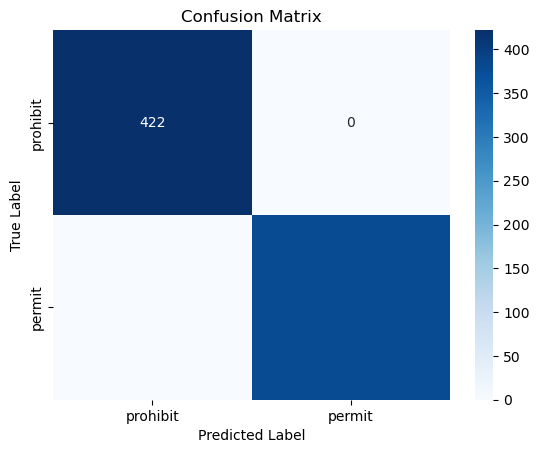

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Specify labels
labels = ['prohibit', 'permit']

# Create a heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set axis labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# Show the plot
plt.show()


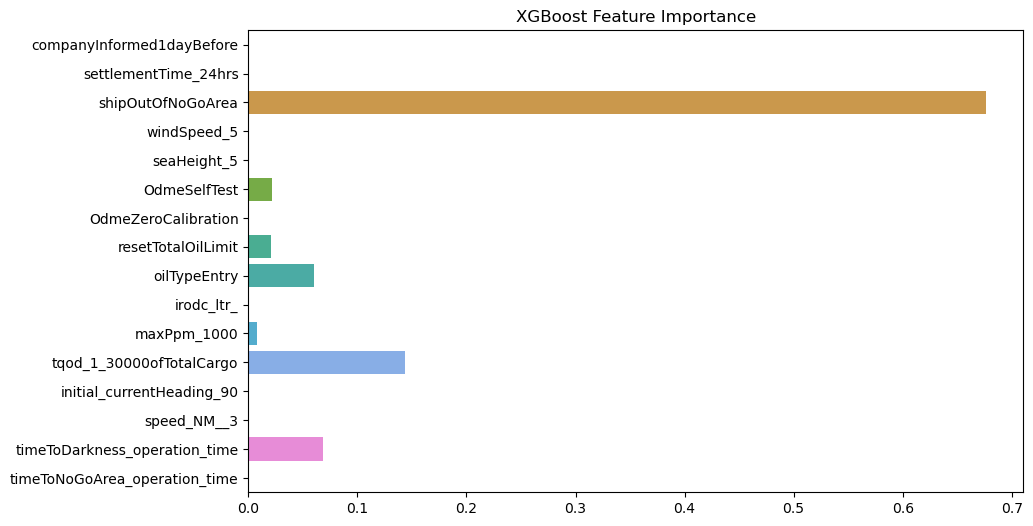

In [30]:
import seaborn as sns  # Import seaborn for plotting
# Plot the feature importance of the XGBoost model
# Create a bar plot with feature importances on the x-axis and feature names on the y-axis
plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=X.columns)
plt.title('XGBoost Feature Importance')
plt.show()




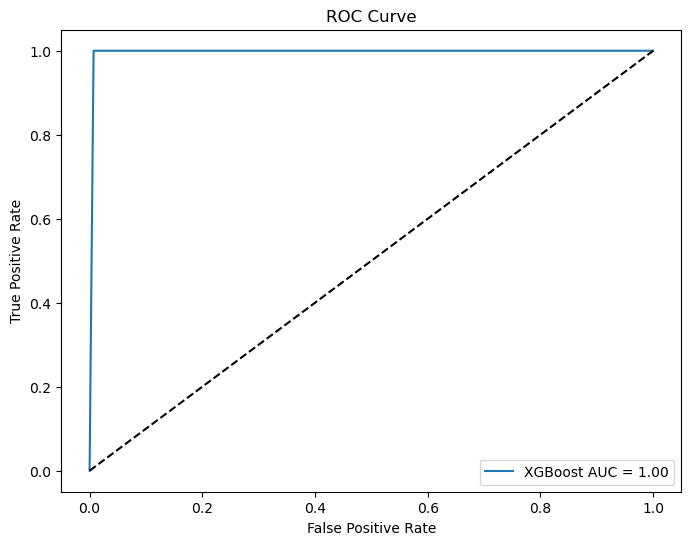

In [31]:
# Import necessary libraries for ROC curve analysis
from sklearn.metrics import roc_curve, auc

# Generate ROC curve for the XGBoost model
# Predict probabilities for the positive class and calculate the false positive rate (fpr) and true positive rate (tpr)
y_prob_xgb = model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)



# Plot ROC curves for both models
# Create a figure with a size of (8, 6) inches
plt.figure(figsize=(8, 6))

# Plot the ROC curve for the XGBoost model with its AUC score
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost AUC = {roc_auc_xgb:.2f}')



# Plot the diagonal line representing a random classifier (no discrimination power)
plt.plot([0, 1], [0, 1], 'k--')

# Set labels and title for the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')

# Display a legend in the lower right corner
plt.legend(loc='lower right')

# Show the ROC curve plot
plt.show()


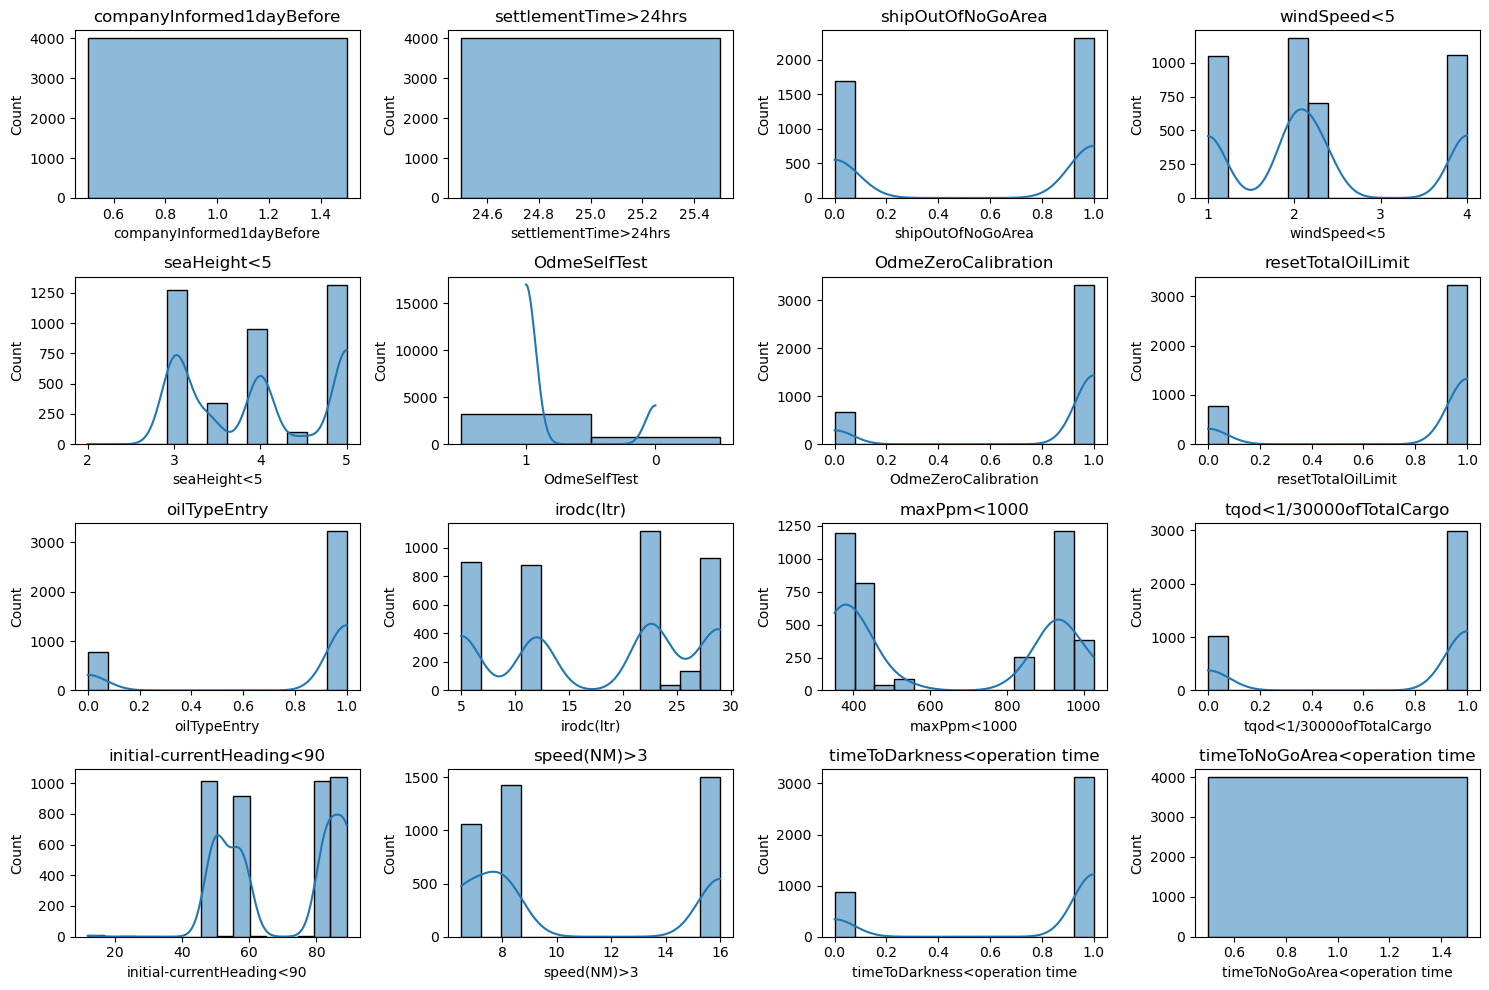

In [32]:
# Define a list of numeric columns for histogram analysis
numeric_cols = ['companyInformed1dayBefore', 'settlementTime>24hrs', 'shipOutOfNoGoArea', 'windSpeed<5', 'seaHeight<5', 'OdmeSelfTest', 'OdmeZeroCalibration', 'resetTotalOilLimit', 'oilTypeEntry', 'irodc(ltr)', 'maxPpm<1000', 'tqod<1/30000ofTotalCargo', 'initial-currentHeading<90', 'speed(NM)>3', 'timeToDarkness<operation time', 'timeToNoGoArea<operation time']

# Create subplots with 4 rows and 4 columns, each with a specified size of (15, 10) inches
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 10))

# Iterate through each numeric column and create a histogram using seaborn's histplot
# This loop generates a 4x4 grid of histograms, each showing the distribution of values for a numeric column.
for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], ax=axes[i//4, i%4], kde=True)
    axes[i//4, i%4].set_title(col)

# Adjust the layout of the subplots for better presentation
plt.tight_layout()

# Display the subplots
plt.show()


c:\Users\yalim\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


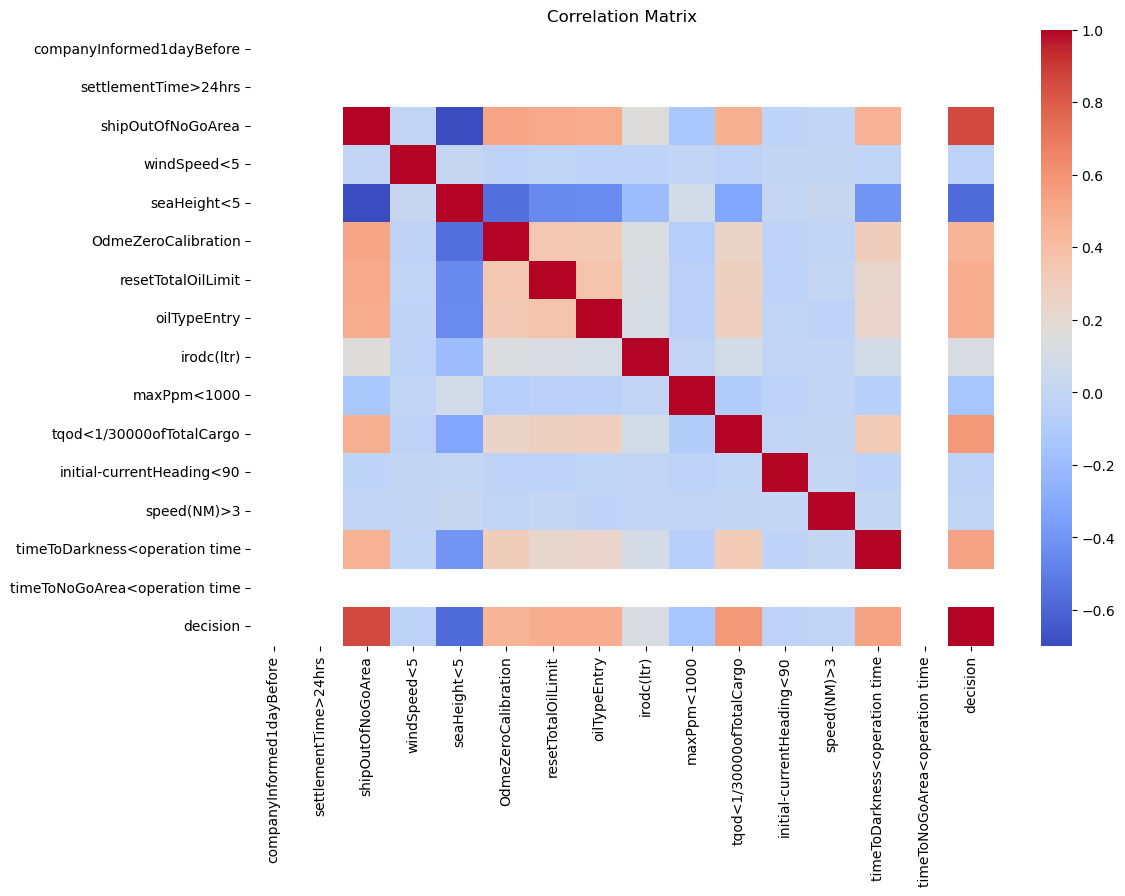

In [33]:
# Calculate correlation matrix
correlation_matrix = data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


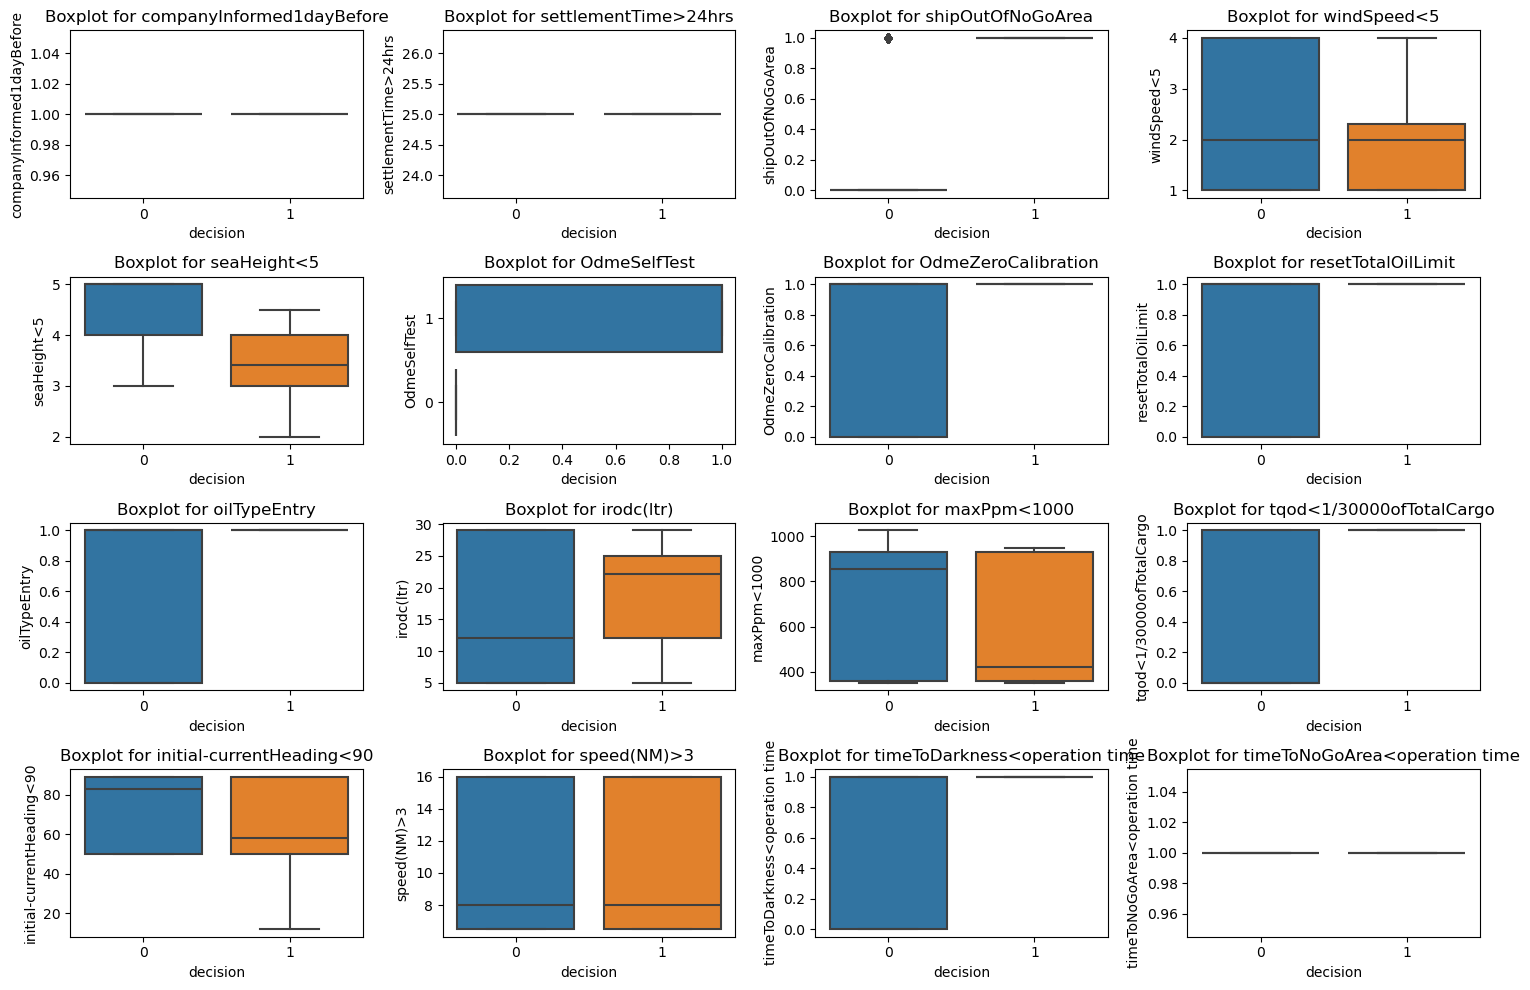

In [34]:
# Create boxplots for numeric columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    plt.subplot(4, 4, i+1)
    sns.boxplot(x='decision', y=col, data=data)
    plt.title(f'Boxplot for {col}')
plt.tight_layout()
plt.show()


In [68]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with the XGBoost model
cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean()}")


Cross-Validation Scores: [0.9984375 0.996875  1.        0.9984375 1.       ]
Mean Accuracy: 0.99875


In [69]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=3)
grid_result = grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and corresponding accuracy
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Accuracy: {grid_result.best_score_}")


Best Parameters: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50}
Best Accuracy: 0.9990627928772259


In [70]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a Random Forest classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train)

# Evaluate the Random Forest model
rf_accuracy = rf_model.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {rf_accuracy}")


Random Forest Accuracy: 1.0


[21:04:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


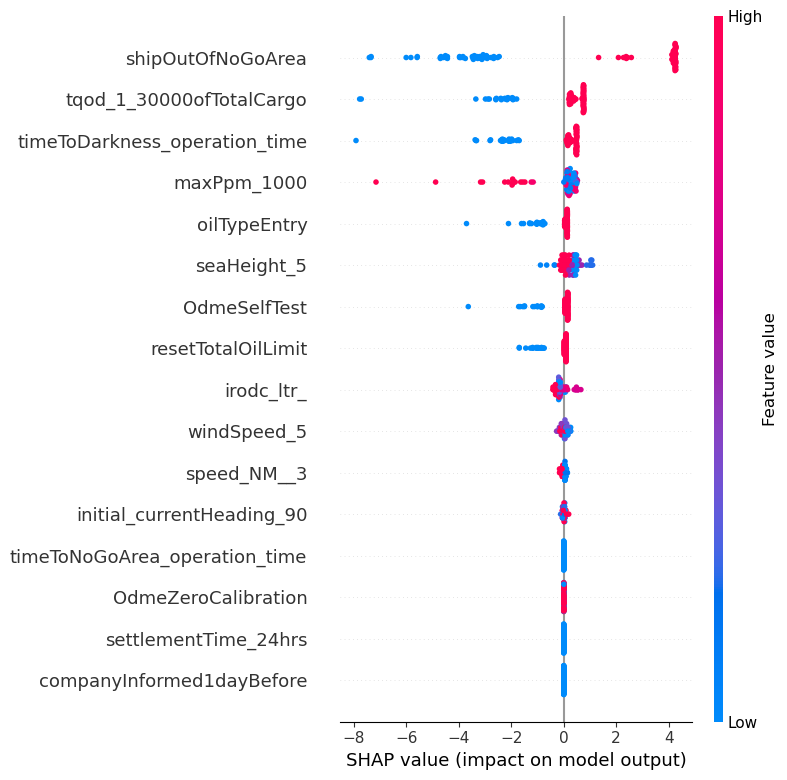

In [74]:
import shap

# Create an explainer object using the XGBoost model
explainer = shap.TreeExplainer(model)

# Calculate SHAP values for a sample of the test data
shap_values = explainer.shap_values(X_test_scaled[:100])

# Plot the summary plot for feature importance using SHAP
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)


In [ ]:
from lime import lime_tabular
from lime.lime_tabular import LimeTabularExplainer

# Create an explainer object using the XGBoost model
explainer = LimeTabularExplainer(X_train_scaled, mode='classification', feature_names=X.columns)

# Explain the prediction for a sample from the test data
exp = explainer.explain_instance(X_test_scaled[0], model.predict_proba)

# Plot the explanation
exp.show_in_notebook(show_table=True, show_all=False)


In [83]:
from sklearn.metrics import precision_score, recall_score

# Example custom evaluation metrics
y_pred_custom = model.predict(X_test_scaled)
precision = precision_score(y_test, y_pred_custom)
recall = recall_score(y_test, y_pred_custom)

print(f"Precision: {precision}")
print(f"Recall: {recall}")


Precision: 1.0
Recall: 1.0


In [84]:
import joblib

# Save the model to a file
joblib.dump(model, 'xgboost_model.joblib')


['xgboost_model.joblib']

In [85]:
# Example logging statement
import logging

logging.basicConfig(level=logging.INFO)
logging.info("Started training the XGBoost model.")


INFO:root:Started training the XGBoost model.


In [86]:
# Example check for missing values
missing_values = data.isnull().sum()
print("Missing Values:")
print(missing_values)

# Example imputation of missing values
data.fillna(data.mean(), inplace=True)


Missing Values:
companyInformed1dayBefore        0
settlementTime>24hrs             0
shipOutOfNoGoArea                0
windSpeed<5                      0
seaHeight<5                      0
OdmeSelfTest                     0
OdmeZeroCalibration              0
resetTotalOilLimit               0
oilTypeEntry                     0
irodc(ltr)                       0
maxPpm<1000                      0
tqod<1/30000ofTotalCargo         0
initial-currentHeading<90        0
speed(NM)>3                      0
timeToDarkness<operation time    0
timeToNoGoArea<operation time    0
decision                         0
dtype: int64


In [87]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Example regression metrics
y_pred_regression = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred_regression)
mse = mean_squared_error(y_test, y_pred_regression)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")


Mean Absolute Error: 0.0
Mean Squared Error: 0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
os.chdir('/content/gdrive/My Drive/spill')

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam


In [ ]:
# Create two directories for 'train' and 'validation' datasets
train_dir = os.path.join('train')
validation_dir = os.path.join('validation')

# Resize and augment images
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2, zoom_range=0.2,
                                   horizontal_flip=True, fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale only for test data

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150),
                                                    batch_size=5, class_mode='binary')

# Create a generator for validation data
validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150),
                                                        batch_size=5, class_mode='binary')


In [ ]:
# Create Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Model Compile
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])


In [ ]:

history = model.fit(train_generator, steps_per_epoch=10, epochs=20,
                    validation_data=validation_generator, validation_steps=50)


In [ ]:
# Extract training history
training_loss = history.history['loss']
training_acc = history.history['accuracy']
validation_loss = history.history['val_loss']
validation_acc = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [ ]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs[:len(training_loss)], training_loss, 'bo', label='Training Loss')
plt.plot(epochs[:len(validation_loss)], validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs[:len(training_acc)], training_acc, 'bo', label='Training Accuracy')
plt.plot(epochs[:len(validation_acc)], validation_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
